In [10]:
import numpy as np
import matplotlib.pyplot as plt

## 2.1 Model building and generate random vehicle input  


First, we need to generate random vehicle arrival times that follows the poisson distribution. In this case, the arrival times are directly representing the time that the vehicle is loaded on the road. We assume that the arrival rate of vehicles is 3000/3600, meaning that there will be 3000 vehicles loading on the road in one hour. And we use the method that mentioned in th Sheldon M. Ross's simulation book to decide when to stop generate new vehicle.

In [33]:
def generate_poisson_distribution_random_variable(lmbda, target_std_dev):
    generated_arrivals = []
    
    # Generate at least 100 data values
    for _ in range(100):  
        U = np.random.random()
        i = 0
        p = np.exp(-lmbda)
        F = p

        while U >= F:
            i += 1
            p = (lmbda * p) / i
            F += p

        generated_arrivals.append(i)  # units are in seconds

    k = 101
    while True:
        U = np.random.random()
        i = 0
        p = np.exp(-lmbda)
        F = p

        while U >= F:
            i += 1
            p = (lmbda * p) / i
            F += p

        generated_arrivals.append(i)  # units are in seconds

        # Calculate the sample standard deviation
        std_dev = np.std(generated_arrivals)

        # Check the stopping condition
        if (std_dev / np.sqrt(k)) < target_std_dev:
            break

        k += 1

    return generated_arrivals

# Example usage
arrival_rate = 3000 / 3600  # Arrival rate of 3000 vehicles per hour
target_std_dev = 200  # Set the acceptable value for the standard deviation
arrival_times = generate_poisson_distribution_random_variable(arrival_rate, target_std_dev)
print(arrival_times)
print('vehicle number:',len(arrival_times))

[1, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 2, 1, 0, 3, 0, 1, 1, 0, 1, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 1, 4, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 3, 0, 1, 1, 0, 1, 0, 1, 3, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 1, 0, 1, 0, 3, 2, 2, 0, 2, 0, 2]
vehicle number: 101


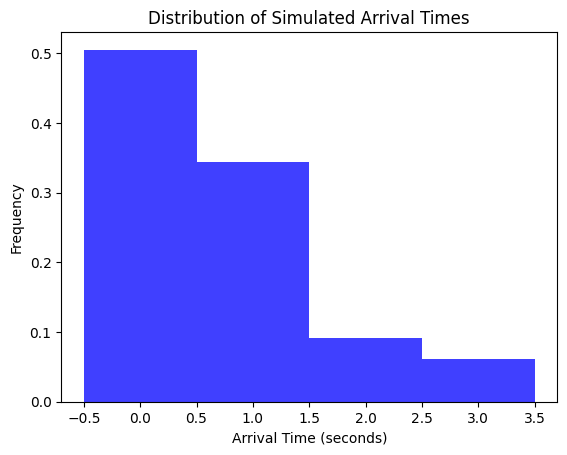

In [34]:
# Plot the distribution of arrival times
plt.hist(arrival_times, bins=np.arange(min(arrival_times), max(arrival_times) + 1) - 0.5, density=True, alpha=0.75, color='b')
plt.title('Distribution of Simulated Arrival Times')
plt.xlabel('Arrival Time (seconds)')
plt.ylabel('Probability')
plt.show()

After generating the vehicles by python, we write them to the xml file called AH2174_2023_project1_section2.rou.xml. All these vehicles will go through from edge 1 to edge 5. We assume there are two types of vehicle. One is 'Car', its acceleration is 2.5 m/s2, its deceleration is 5m/s2, and its vehicle legnth is 5 meters. Another one is 'Bus', its accelaration is 1.5 m/s2, its deceleration is 4 m/s2, and it vehicle length is 18 meters. And we assign the vehicle type randomly to each vehicle. But considering that normally there will be more cars on the road, so we assume a vehicle 70 percent probability to be a car.  

In [45]:
# Write arrivals to a file (e.g., sumo_test.arr.xml)
with open('AH2174_2023_project1_section2.rou.xml', 'w') as f:
    f.write('<routes>\n')
    f.write('<vType accel="2.5" decel="5.0" id="Car" length="5.0" maxSpeed="40" sigma="0.0"/>\n')
    f.write('<vType accel="1.5" decel="4.0" id="Bus" length="18.0" maxSpeed="25" sigma="0.0"/>\n')
    f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

    # Sort vehicles by departure time
    sorted_arrival_times = sorted(enumerate(arrival_times), key=lambda x: x[1])

    for num_vehicles,time in sorted_arrival_times:
        vehicle_type = np.random.choice(['Car', 'Bus'], size=1,p=[0.7, 0.3])[0]
        f.write(f'<vehicle depart="{time}" route="r1" id="{num_vehicles}" type="{vehicle_type}"/>\n')
    f.write('</routes>')

To check the number of vehicles loaded on the specific highway section in a SUMO simulation, we can use the traci module, which is the interface for interacting with a running SUMO simulation.  We need to query the vehicles that are currently present on the edges representing the highway section of interest.

In [51]:
import traci
import traci.constants as tc

# Start the SUMO simulation with your configuration file (e.g., sumo_test.sumocfg)
traci.start(["sumo", "-c", "AH2174_2023_project1_section2.sumo.cfg"])

# Run the simulation for a certain number of steps
i=1
simulation_steps = 1000

# Define the edges representing the highway section (e.g., edge1, edge2, etc.)
highway_edges = ["edge1", "edge2", "edge3", "edge4", "edge5"]
for _ in range(simulation_steps):
    traci.simulationStep()
    IDList = traci.vehicle.getIDList()
    # print the vehicle info when not empty
    if len(IDList):
        # Get the list of currently loaded vehicles on the highway section
        loaded_vehicles_on_highway = [v for v in IDList if traci.vehicle.getRoadID(v) in highway_edges]
        # Get the number of loaded vehicles on the highway section
        num_loaded_vehicles_on_highway = len(loaded_vehicles_on_highway)  
        print(i, IDList)
        print(f'Number of loaded vehicles on the highway section: {num_loaded_vehicles_on_highway}')
    i=i+1
traci.close()
print("SUMO simulation finished!")


1 ('1',)
Number of loaded vehicles on the highway section: 1
2 ('1',)
Number of loaded vehicles on the highway section: 1
3 ('1',)
Number of loaded vehicles on the highway section: 1
4 ('1',)
Number of loaded vehicles on the highway section: 1
5 ('1',)
Number of loaded vehicles on the highway section: 1
6 ('1', '4')
Number of loaded vehicles on the highway section: 2
7 ('1', '4')
Number of loaded vehicles on the highway section: 2
8 ('1', '4')
Number of loaded vehicles on the highway section: 2
9 ('1', '4', '7')
Number of loaded vehicles on the highway section: 3
10 ('1', '4', '7')
Number of loaded vehicles on the highway section: 3
11 ('1', '4', '7')
Number of loaded vehicles on the highway section: 3
12 ('1', '4', '7')
Number of loaded vehicles on the highway section: 3
13 ('1', '4', '7', '8')
Number of loaded vehicles on the highway section: 4
14 ('1', '4', '7', '8')
Number of loaded vehicles on the highway section: 4
15 ('1', '4', '7', '8')
Number of loaded vehicles on the highway 

We let the simulation run 100 steps first, and print the ID and number of loaded vehicles on the highway section in each step. As the results shown, we can observe that vehicles are dynamically entering and exiting the highway, which is expected in a traffic simulation. Factors such as vehicle behavior of different vehicle types, lane changes contribute to this variability; It is also important to notice that not all vehicles may be loaded onto the highway at the start of the simulation, even they depart at 0th second. The simulation may need some steps to fully introduce vehicles into the network; The number of loaded vehicles may also depend on the duration of the simulation. Running the simulation for a longer period may result in more vehicles entering and impacting the highway section.

## 2.2 Simulation output

## 2.3 Alternative scenario